<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyogo202104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 6.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=a6f69b668f28d4aadc273f986a4ee95027444f03e5617d0e9f2bf12b0cca03a9
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [2]:
import datetime
import pathlib
import re

In [3]:
import pandas as pd
import requests

from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [4]:
# スクレイピング
def fetch_soup(url, parser="html.parser"):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, parser)

    return soup

In [5]:
# ファイルダウンロード
def fetch_file(url, dir="."):

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    if not p.exists():

        r = requests.get(url)
        r.raise_for_status()

        with p.open(mode="wb") as fw:
            fw.write(r.content)

    return p

In [6]:
# 日付変換
def excel2date(data):

    flg_is_serial = data.astype("str").str.isdigit()

    fromSerial = pd.to_datetime(data[flg_is_serial].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))
    fromString = pd.to_datetime(data[~flg_is_serial], errors="coerce")

    result = pd.concat([fromString, fromSerial])

    return result

# スクレイピング

In [7]:
headers = [
    ["番号", "発表日", "年代", "性別", "管轄", "居住地", "職業", "発症日", "渡航歴", "備考欄"],
    ["番号", "発表日", "年代", "性別", "管轄", "居住地", "職業", "発症日", "接触歴_有", "接触歴_無", "接触歴_調査中", "備考欄"],
]

In [8]:
links = [
    {
        "url": "https://web.pref.hyogo.lg.jp/kk03/documents/corona-kanjajokyou1.xlsx",
        "skip": 5,
        "header": headers[0],
        "usecols": "B:K",
    },
    {
        "url": "https://web.pref.hyogo.lg.jp/kk03/documents/corona-kanjajokyou2.xlsx",
        "skip": 3,
        "header": headers[1],
        "usecols": "B:M",
    },
    {
        "url": "https://web.pref.hyogo.lg.jp/kk03/documents/corona-kanjajokyou3.xlsx",
        "skip": 5,
        "header": headers[1],
        "usecols": "B:M",
    },
    {
        "url": "https://web.pref.hyogo.lg.jp/kk03/documents/corona-kanjajokyou.xlsx",
        "skip": 5,
        "header": headers[1],
        "usecols": "B:M",
    },
]

In [9]:
url = "https://web.pref.hyogo.lg.jp/kk03/corona_hasseijyokyo.html"

In [10]:
soup = fetch_soup(url)

In [11]:
tag = soup.find("a", class_="icon_excel", text=re.compile("^新型コロナウイルスに感染した患者の状況"))

In [12]:
if tag:
    links[-1]["url"] = urljoin(url, tag.get("href")) 

# データラングリング

In [13]:
dfs = []

for d in links:

    p = fetch_file(d["url"])

    df_tmp = pd.read_excel(p, skiprows = d["skip"], usecols=d["usecols"], header=None).dropna(thresh=3)

    df_tmp.set_axis(d["header"], axis=1, inplace=True)

    df_tmp.drop_duplicates(subset="番号", inplace=True)

    df_tmp.set_index("番号", inplace=True)

    df_tmp["症状"] = df_tmp["発症日"].where(df_tmp["発症日"].isin(["症状なし", "調査中", "非公表", "なし"]))

    df_tmp["発表日YMD"] = excel2date(df_tmp["発表日"])
    df_tmp["発症日YMD"] = excel2date(df_tmp["発症日"])

    dfs.append(df_tmp)

In [14]:
# 結合
df = pd.concat(dfs).sort_index()

In [15]:
# CSVファイルに保存
df.to_csv("data.csv", encoding="utf_8_sig")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 22511 entries, 1.0 to 22607.0
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   発表日      22511 non-null  object        
 1   年代       22511 non-null  object        
 2   性別       22511 non-null  object        
 3   管轄       22511 non-null  object        
 4   居住地      22511 non-null  object        
 5   職業       22510 non-null  object        
 6   発症日      22510 non-null  object        
 7   渡航歴      699 non-null    object        
 8   備考欄      11133 non-null  object        
 9   症状       10071 non-null  object        
 10  発表日YMD   22511 non-null  datetime64[ns]
 11  発症日YMD   12437 non-null  datetime64[ns]
 12  接触歴_有    9861 non-null   object        
 13  接触歴_無    9 non-null      object        
 14  接触歴_調査中  11932 non-null  object        
dtypes: datetime64[ns](2), object(13)
memory usage: 2.7+ MB


In [17]:
# 発症日数計算
df["発症日数"] = df["発表日YMD"] - df["発症日YMD"]

In [18]:
# 発症日が21日以上前
df[df["発症日数"].abs() > pd.Timedelta(20, unit="D")]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,症状,発表日YMD,発症日YMD,接触歴_有,接触歴_無,接触歴_調査中,発症日数
番号,,,,,,,,,,,,,,,,
106.0,43911,80,女性,宝塚,宝塚市,無職,43890,なし,介護老人保健施設グリーンアルス伊丹デイケアを利用,NaN,2020-03-21,2020-02-29,NaN,NaN,NaN,21 days
289.0,43931,30,男性,神戸,神戸市,自営業,43900,なし,No.213の濃厚接触者（神戸西署）\n（5/16再発、神戸N0.283),NaN,2020-04-10,2020-03-10,NaN,NaN,NaN,31 days
417.0,43936,50,女性,伊丹,伊丹市,無職,43915,なし,No.373の濃厚接触者,NaN,2020-04-15,2020-03-25,NaN,NaN,NaN,21 days
437.0,43937,70,男性,神戸,神戸市,調査中,43913,不明,神戸市立医療センター中央市民病院に入院中の患者,NaN,2020-04-16,2020-03-23,NaN,NaN,NaN,24 days
541.0,43942,30,女性,西宮,西宮市,フリーランス,43912,あり,行動歴調査中,NaN,2020-04-21,2020-03-22,NaN,NaN,NaN,30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20127.0,44286,80,女性,伊丹,伊丹健康福祉事務所管内,無職,44260,NaN,NaN,NaN,2021-03-31,2021-03-05,NaN,NaN,○,26 days
20305.0,44287,20,女性,宝塚,宝塚健康福祉事務所管内,学生,44265,NaN,陽性患者の濃厚接触者,NaN,2021-04-01,2021-03-10,○,NaN,NaN,22 days
20490.0,44288,40,男性,宝塚,宝塚市,非公表,44530,NaN,NaN,NaN,2021-04-02,2021-11-30,NaN,NaN,○,-242 days


In [19]:
# 発症日の年調整
df["発症日YMD"] = df["発症日YMD"].mask(df["発症日数"] < pd.Timedelta(-180, unit="D"), df["発症日YMD"] - pd.offsets.DateOffset(years=1))
df["発症日YMD"] = df["発症日YMD"].mask(df["発症日数"] > pd.Timedelta(180, unit="D"), df["発症日YMD"] + pd.offsets.DateOffset(years=1))

In [20]:
# 発症日数再計算
df["発症日数"] = df["発表日YMD"] - df["発症日YMD"]

In [21]:
# 発症日が21日以上前
df[df["発症日数"].abs() > pd.Timedelta(20, unit="D")]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,症状,発表日YMD,発症日YMD,接触歴_有,接触歴_無,接触歴_調査中,発症日数
番号,,,,,,,,,,,,,,,,
106.0,43911,80,女性,宝塚,宝塚市,無職,43890,なし,介護老人保健施設グリーンアルス伊丹デイケアを利用,NaN,2020-03-21,2020-02-29,NaN,NaN,NaN,21 days
289.0,43931,30,男性,神戸,神戸市,自営業,43900,なし,No.213の濃厚接触者（神戸西署）\n（5/16再発、神戸N0.283),NaN,2020-04-10,2020-03-10,NaN,NaN,NaN,31 days
417.0,43936,50,女性,伊丹,伊丹市,無職,43915,なし,No.373の濃厚接触者,NaN,2020-04-15,2020-03-25,NaN,NaN,NaN,21 days
437.0,43937,70,男性,神戸,神戸市,調査中,43913,不明,神戸市立医療センター中央市民病院に入院中の患者,NaN,2020-04-16,2020-03-23,NaN,NaN,NaN,24 days
541.0,43942,30,女性,西宮,西宮市,フリーランス,43912,あり,行動歴調査中,NaN,2020-04-21,2020-03-22,NaN,NaN,NaN,30 days
1587.0,44051,60,女性,朝来,朝来健康福祉事務所管内,非公表,44030,NaN,陽性患者の濃厚接触者,NaN,2020-08-08,2020-07-18,○,NaN,NaN,21 days
1680.0,44054,30,女性,尼崎,尼崎市,無職,44025,NaN,NaN,NaN,2020-08-11,2020-07-13,NaN,NaN,○,29 days
1683.0,44054,10,男性,尼崎,尼崎市,学生,44033,NaN,No1277の濃厚接触者 尼崎市立高等学校の生徒,NaN,2020-08-11,2020-07-21,○,NaN,NaN,21 days
2092.0,44065,20,男性,宝塚,宝塚健康福祉事務所管内,学生,44044,NaN,陽性患者の濃厚接触者,NaN,2020-08-22,2020-08-01,○,NaN,NaN,21 days


In [22]:
# 集計期間作成
strdt = df["発表日YMD"].min()
enddt = df["発表日YMD"].max()

dt_range = pd.date_range(strdt, enddt)

# 可視化

In [23]:
import matplotlib.pyplot as plt

In [24]:
import japanize_matplotlib

## 発症日数

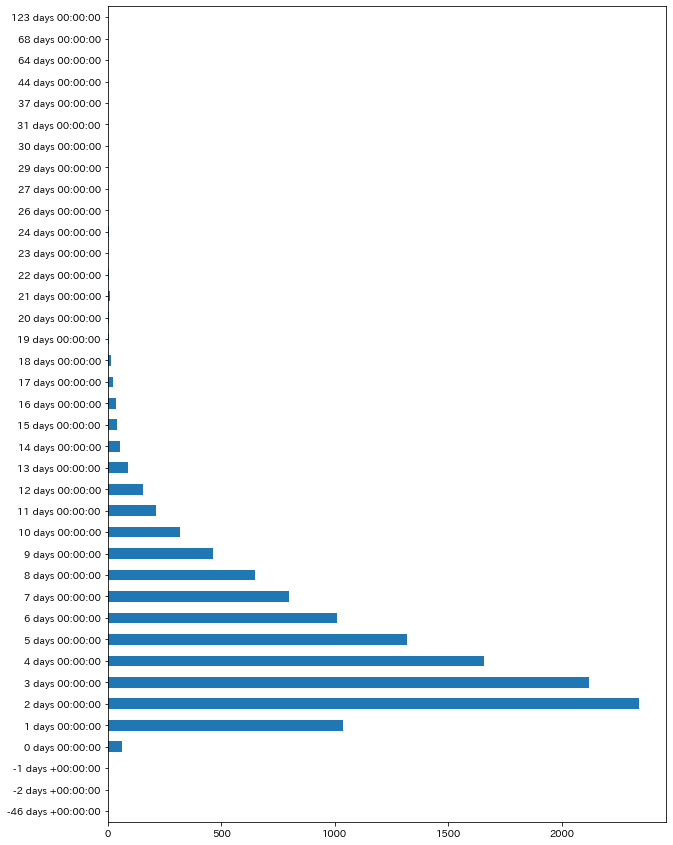

In [25]:
df["発症日数"].value_counts().sort_index().plot.barh(figsize=(10, 15))

# グラフを保存
plt.savefig("01.png", dpi=200, bbox_inches="tight")
plt.show()

## 日別陽性者数

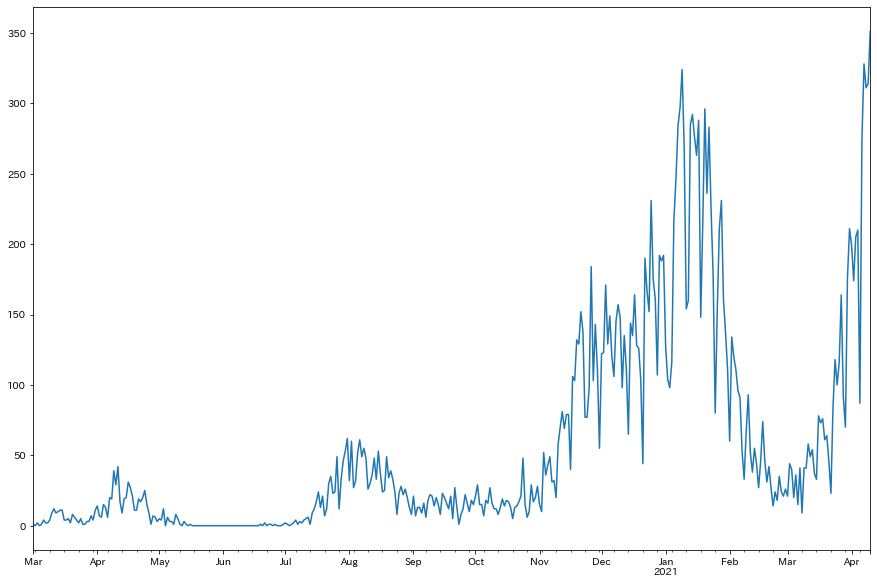

In [26]:
df["発表日YMD"].value_counts().reindex(index=dt_range, fill_value=0).plot(figsize=(15, 10))

## 年代別

In [27]:
df["年代"] = df["年代"].astype(str)

df["年代"].replace(
    {
        "10": "10代",
        "20": "20代",
        "30": "30代",
        "40": "40代",
        "50": "50代",
        "60": "60代",
        "70": "70代",
        "80": "80代",
    },
    inplace=True,
)

In [28]:
age_list = ["10歳未満","10代", "20代", "30代", "40代", "50代", "60代", "70代", "80代", "90歳以上", "非公表"]

df_age = df["年代"].value_counts().reindex(age_list, fill_value=0)

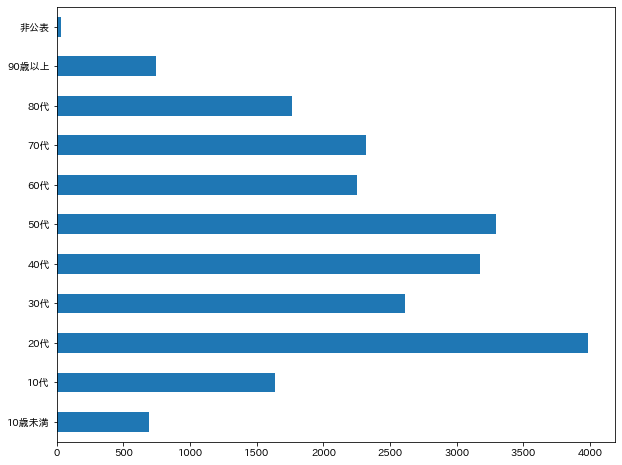

In [29]:
df_age.plot.barh(figsize=(10, 8))

## 性別

In [30]:
df["性別"].replace(
    {
        "男": "男性",
        "女": "女性",
    },
    inplace=True,
)

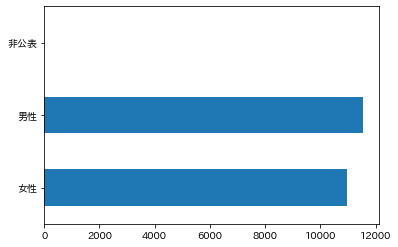

In [31]:
df["性別"].value_counts().sort_index().plot.barh()

## 管轄別

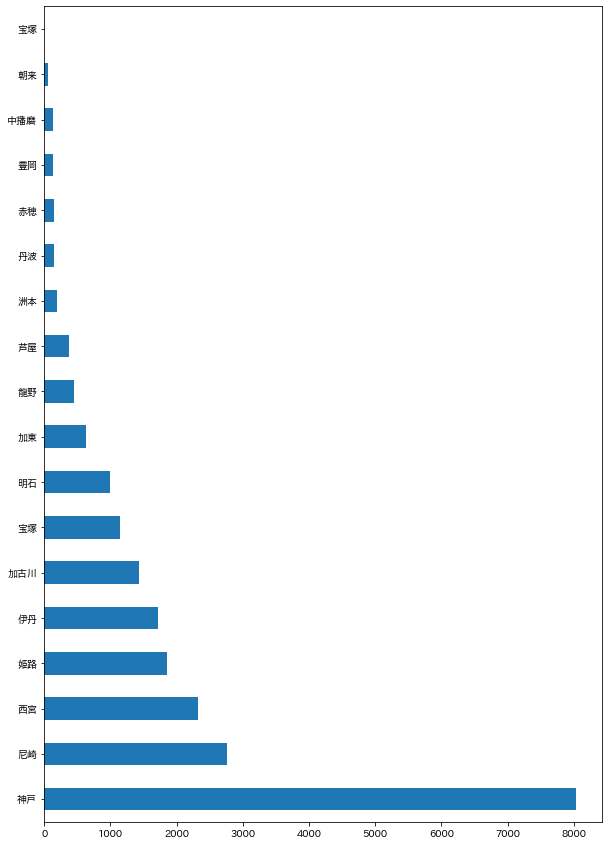

In [32]:
df["管轄"].value_counts().plot.barh(figsize=(10, 15))

## 居住地別

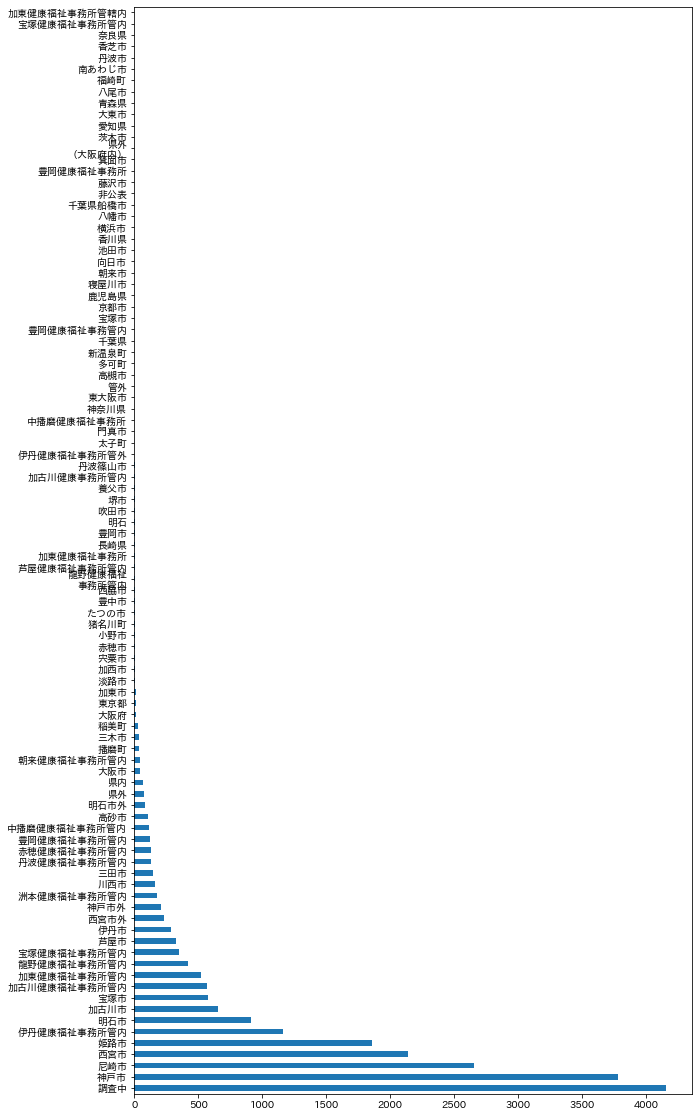

In [33]:
df["居住地"].value_counts().plot.barh(figsize=(10, 20))

## 職業別 

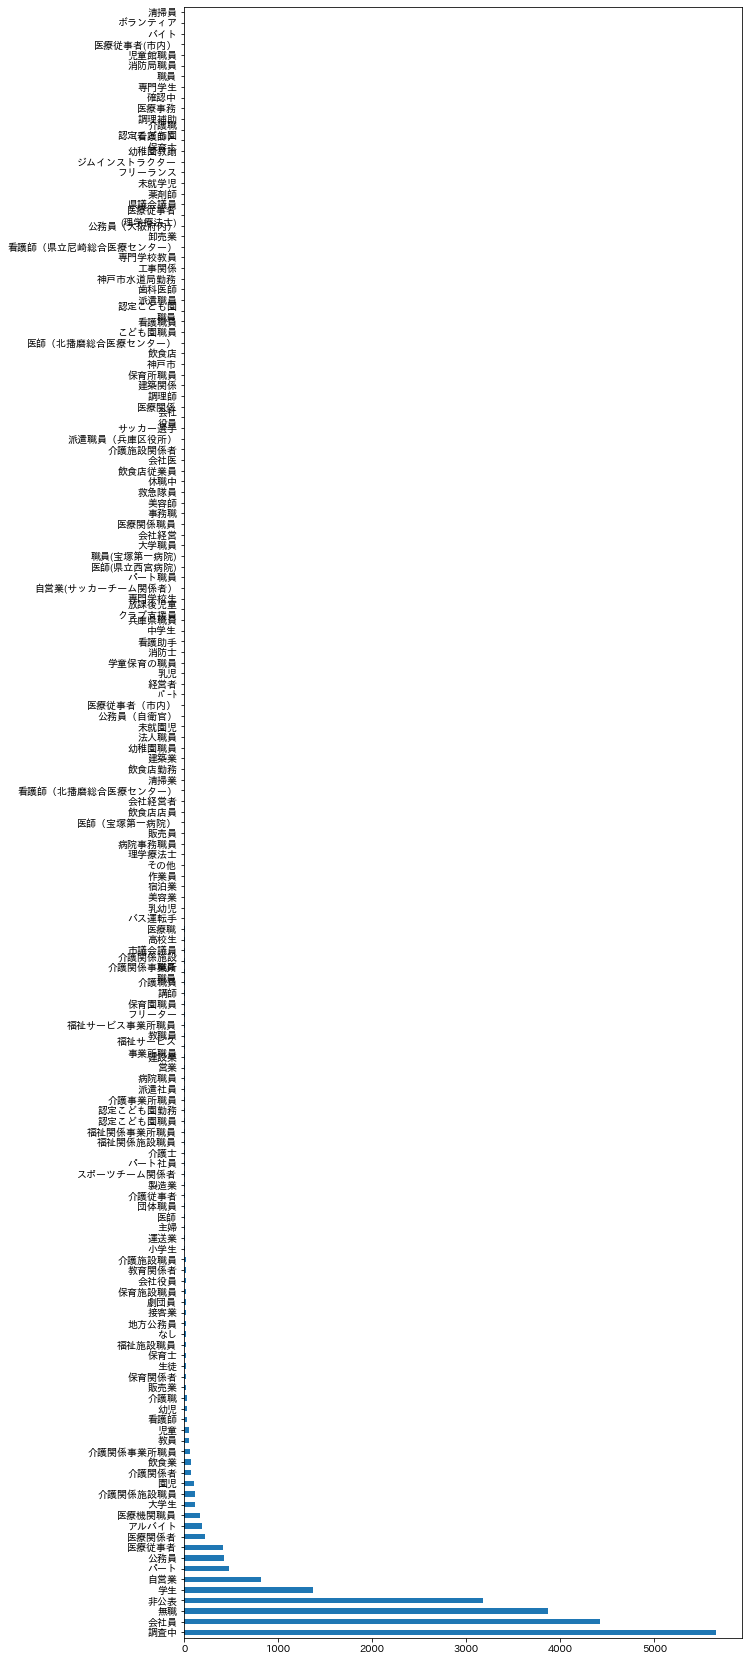

In [34]:
df["職業"].value_counts().plot.barh(figsize=(10, 30))